In [46]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

GENOMES = { "mm10" : "/users/kcochran/genomes/mm10_no_alt_analysis_set_ENCODE.fasta",
            "hg38" : "/users/kcochran/genomes/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta" }

ROOT = "/users/kcochran/projects/cs197_cross_species_domain_adaptation/"
DATA_DIR = ROOT + "data/"

SPECIES = ["mouse", "human"]

TFS = ["CTCF", "CEBPA", "HNF4A", "RXRA"]

EPSILON = 0.00001

#PEAK_FILE = "/users/tkanell/team_covariates/data/human/accessibility/peaks.bed"
ACCESSIBILITY_FILE = "/users/angezhao/cs197_covariates/data/human/accessibility/reads.bigWig"
POS_BIND = "/users/angezhao/cs197_covariates/data/human/CTCF/chr3toY_pos_shuf.bed.gz"
#POS_BIND = '/users/angezhao/cs197_covariates/data/human/CTCF/control.pos.bigWig'

#We want to get the positive binding sites chrom 3 to y pos bed.gz
#Then we're going to open that, get into a numpy array although we might not need to. 

In [47]:

import gzip
from collections import defaultdict
import random
import numpy as np
from pyfaidx import Fasta
from torch.utils.data import Dataset
import pyBigWig
from matplotlib import pyplot as plt
import pandas as pd

In [48]:
def expand_window(start, end, target_len):
    midpoint = (start + end) / 2
    if not midpoint.is_integer() and target_len % 2 == 0:
        midpoint = midpoint - 0.5
    if midpoint.is_integer() and target_len % 2 != 0:
        midpoint = midpoint - 0.5
    new_start = midpoint - target_len / 2
    new_end = midpoint + target_len / 2
    
    assert new_start.is_integer(), new_start
    assert new_end.is_integer(), new_end
    assert new_start >= 0
    assert new_end - new_start == target_len, (new_end, new_start, target_len)
    
    return int(new_start), int(new_end)



In [49]:
class Generator(Dataset):
    letter_dict = {
        'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
        'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
        'T':[0,0,0,1],'N':[0,0,0,0]}

    def __init__(self, species, tf, train_val_test,
                 seq_len = 2114, profile_len = 1000, return_labels = True):
        
        assert train_val_test in ["train", "val", "test"]
        print("Beginning Init")
        self.pos_b = POS_BIND
            
        self.accessibility = ACCESSIBILITY_FILE #BIGWIGS_DIR + species + "/" + tf + "/final.pos.bigWig"
        self.prof_len = profile_len
        self.max_jitter = 0
        self.return_labels = return_labels
        
        #self.genome_file = GENOMES[species]
        self.genome_file = GENOMES["hg38"]
        self.seq_len = seq_len

        self.set_len()
        self.coords = self.get_coords()
        #self.seqs_onehot = self.convert(self.coords)
        self.profiles, self.logcounts_sum, self.logcounts_mean, self.logcounts_max = self.get_profiles_and_logcounts(self.coords)


    def __len__(self):
        return self.len
    
    
    def set_len(self):
        with open(self.pos_b) as f:
            gzip_fd = gzip.open(self.pos_b)
            self.len = sum([1 for _ in gzip_fd])


    def get_coords(self):
        with open(self.pos_b) as pos:
            posf = gzip.open(self.pos_b)
            #coords_tmp = [line.split()[:3] for line in posf]
            coords_tmp = [line.decode().split()[:3] for line in posf]  # expecting bed file format
        
        i = 0
        coords = []
        for coord in coords_tmp:
            #print(coord)
            chrom, start, end = coord[0], int(coord[1]), int(coord[2])
            window_start, window_end = expand_window(start, end,
                                                     self.seq_len + 2 * self.max_jitter)
            coords.append((coord[0], window_start, window_end))  # no strand consideration
            if i == 0:
                print(coords[0])
                i += 1
            
        return coords
            

    def get_profiles_and_logcounts(self, coords):
        print("inside profiles")
        profiles = []
        logcounts_sum = []
        logcounts_mean = []
        logcounts_max = []

        with pyBigWig.open(self.accessibility) as accessibility_reader:
            for chrom, start, end in coords:
                #print (chrom, " is chrom. ", start, " is start. ", end, " is end.")
                prof_start, prof_end = expand_window(start, end,
                                                 self.prof_len + 2 * self.max_jitter)
                pos_profile = np.array(
                    accessibility_reader.values(chrom, prof_start, prof_end))
                pos_profile[np.isnan(pos_profile)] = EPSILON
                profile = np.array(pos_profile)

                profiles.append(profile)
                logcounts_sum.append(np.array(np.log(np.sum(pos_profile) + EPSILON)))
                logcounts_mean.append(np.array(np.log(np.mean(pos_profile) + EPSILON)))
                logcounts_max.append(np.array(np.log(np.max(pos_profile) + EPSILON)))
                
        print("Finished going thorugh it all. ")        
        profiles = np.array(profiles)
        logcounts_sum = np.array(logcounts_sum)
        logcounts_mean = np.array(logcounts_mean)
        logcounts_max = np.array(logcounts_max)

        
        print(profiles.shape, " is 0th in profiles")
        
        return profiles, logcounts_sum, logcounts_mean, logcounts_max
                

    def convert(self, coords):
        seqs_onehot = []
        with Fasta(self.genome_file) as converter:
            for coord in coords:
                chrom, start, stop = coord
                print (chrom, " is chrom")
                assert chrom in converter
                seq = converter[chrom][start:stop].seq
                seq_onehot = np.array([self.letter_dict.get(x,[0,0,0,0]) for x in seq])
                seqs_onehot.append(seq_onehot)

        seqs_onehot = np.array(seqs_onehot)
        return seqs_onehot


    def __getitem__(self, batch_index):	
        # get coordinates
        onehot = self.seqs_onehot[batch_index]
        assert onehot.shape[0] > 0, onehot.shape

        onehot = torch.tensor(onehot, dtype=torch.float).permute(1, 0)
        
        if not self.return_labels:
            return onehot
        else:
            # get profiles and logcounts for the two strands
            profiles = self.profiles[batch_index]
            logcounts = self.logcounts[batch_index]

            profiles = torch.tensor(profiles, dtype=torch.float)
            logcounts = torch.tensor(logcounts, dtype=torch.float)
            return onehot, profiles, logcounts


In [50]:
class Generator_Neg(Dataset):
    letter_dict = {
        'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
        'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
        'T':[0,0,0,1],'N':[0,0,0,0]}

    def __init__(self, species, tf, train_val_test,
                 seq_len = 2114, profile_len = 1000, return_labels = True):
        
        assert train_val_test in ["train", "val", "test"]
        print("Beginning Init")
        self.pos_b = POS_BIND
            
        self.accessibility = ACCESSIBILITY_FILE #BIGWIGS_DIR + species + "/" + tf + "/final.pos.bigWig"
        self.prof_len = profile_len
        self.max_jitter = 0
        self.return_labels = return_labels
        
        #self.genome_file = GENOMES[species]
        self.genome_file = GENOMES["hg38"]
        self.seq_len = seq_len

        self.set_len()
        self.coords = self.get_coords()
        #self.seqs_onehot = self.convert(self.coords)
        self.profiles, self.logcounts_sum, self.logcounts_mean, self.logcounts_max = self.get_profiles_and_logcounts(self.coords)


    def __len__(self):
        return self.len
    
    
    def set_len(self):
        with open(self.pos_b) as f:
            gzip_fd = gzip.open(self.pos_b)
            self.len = sum([1 for _ in gzip_fd])


    def get_coords(self):
        coords = []
        coords_tmp = np.array(false_negatives_windows)
        for coord in coords_tmp:
            #print(coord)
            chrom, start, end = coord[2], int(coord[3]), int(coord[4])
            window_start, window_end = expand_window(start, end,
                                                     self.seq_len + 2 * self.max_jitter)
            coords.append((coord[2], window_start, window_end))  # no strand consideration

            
        return coords
            

    def get_profiles_and_logcounts(self, coords):
        print("inside profiles")
        profiles = []
        logcounts_sum = []
        logcounts_mean = []
        logcounts_max = []

        with pyBigWig.open(self.accessibility) as accessibility_reader:
            for chrom, start, end in coords:
                #print (chrom, " is chrom. ", start, " is start. ", end, " is end.")
                prof_start, prof_end = expand_window(start, end,
                                                 self.prof_len + 2 * self.max_jitter)
                pos_profile = np.array(
                    accessibility_reader.values(chrom, prof_start, prof_end))
                pos_profile[np.isnan(pos_profile)] = 0
                profile = np.array(pos_profile)

                profiles.append(profile)
                logcounts_sum.append(np.array(np.sum(np.log((pos_profile)))))
                logcounts_mean.append(np.array(np.mea(np.log((pos_profile)))))
                logcounts_max.append(np.array(np.max(np.log((pos_profile)))))
                
        print("Finished going thorugh it all. ")        
        profiles = np.array(profiles)
        logcounts_sum = np.array(logcounts_sum)
        logcounts_mean = np.array(logcounts_mean)
        logcounts_max = np.array(logcounts_max)

        
        print(profiles.shape, " is 0th in profiles")
        
        return profiles, logcounts_sum, logcounts_mean, logcounts_max
                

    def convert(self, coords):
        seqs_onehot = []
        with Fasta(self.genome_file) as converter:
            for coord in coords:
                chrom, start, stop = coord
                #print (chrom, " is chrom")
                assert chrom in converter
                seq = converter[chrom][start:stop].seq
                seq_onehot = np.array([self.letter_dict.get(x,[0,0,0,0]) for x in seq])
                seqs_onehot.append(seq_onehot)

        seqs_onehot = np.array(seqs_onehot)
        return seqs_onehot


    def __getitem__(self, batch_index):	
        # get coordinates
        onehot = self.seqs_onehot[batch_index]
        assert onehot.shape[0] > 0, onehot.shape

        onehot = torch.tensor(onehot, dtype=torch.float).permute(1, 0)
        
        if not self.return_labels:
            return onehot
        else:
            # get profiles and logcounts for the two strands
            profiles = self.profiles[batch_index]
            logcounts = self.logcounts[batch_index]

            profiles = torch.tensor(profiles, dtype=torch.float)
            logcounts = torch.tensor(logcounts, dtype=torch.float)
            return onehot, profiles, logcounts


In [51]:
train_species = "mouse"
tf = "CTCF"
test = Generator(train_species, tf, "val")

Beginning Init
('chr4', 152459793, 152461907)
inside profiles
Finished going thorugh it all. 
(274016, 1000)  is 0th in profiles


In [52]:
'''
Notes from meeting:

Visualize the histogram for conservation:
For conservation file instead of the accessibility file: 
use "/users/angezhao/cs197_covariates/data/human/conservation/conservation.phastCons.bigWig" or the phyloP. phastCons is
a smoothed version while phyloP is a bit noiser. 

Pulling the false negatives:
Use /users/angezhao/cs197_covariates/model_preds/CTCF_human-trained_human-test.preds and 
/users/angezhao/cs197_covariates/model_preds/CTCF_mouse-trained_human-test.preds

Each .preds file is a numpy array -> numpy.loadtxt (name of file) to load -> 5 columns by 4M rows
Each row is a different window
5 replicate model trainings -> can take average or just one column

Use the /users/angezhao/cs197_covariates/data/human/CTCF/chr2.bed.gz file to identify which windows were used. If fewer 
predictions, then just chop off the end of the chr2 file -> should be w/in several thousand in length 
Can try to recreate scatterplot of false negatives/positives as a sanity check. 

False negatives: preds files should all end in human test b/c care mostly about human diseases. Sites that are bound in 
the human model but mouse model doesn't think they're bound. Look at predictions from both mouse and human, w/ human test
For the bound sites, pull false negatives. Difference between human and mouse prediction must be between 0.5 - luckily
this is also equivalent to human pred above 0.5 and mouse below 0.5. 

For the test site, mix of unbound and bound sites. In the bed file: look for the bound sites -> ends in 1, unbound is 
ending in 0.

Potentially create pandas dataframe -> filter the chr2 and then left-join. 

bed -> pandas.read_csv. Potentially unzip before reading in. 

General idea:
Filter for bound sites first in the /users/angezhao/cs197_covariates/data/human/CTCF/chr2.bed.gz file.Then left-join
using windows as key for high sites in human prediction and low sites in mouse prediction. Pull the windows and visualize
them using the accessibility and conservation histograms, potentially filtering the POS_BIND file. 

'''


'\nNotes from meeting:\n\nVisualize the histogram for conservation:\nFor conservation file instead of the accessibility file: \nuse "/users/angezhao/cs197_covariates/data/human/conservation/conservation.phastCons.bigWig" or the phyloP. phastCons is\na smoothed version while phyloP is a bit noiser. \n\nPulling the false negatives:\nUse /users/angezhao/cs197_covariates/model_preds/CTCF_human-trained_human-test.preds and \n/users/angezhao/cs197_covariates/model_preds/CTCF_mouse-trained_human-test.preds\n\nEach .preds file is a numpy array -> numpy.loadtxt (name of file) to load -> 5 columns by 4M rows\nEach row is a different window\n5 replicate model trainings -> can take average or just one column\n\nUse the /users/angezhao/cs197_covariates/data/human/CTCF/chr2.bed.gz file to identify which windows were used. If fewer \npredictions, then just chop off the end of the chr2 file -> should be w/in several thousand in length \nCan try to recreate scatterplot of false negatives/positives as a

In [53]:
'''
General idea:
Filter for bound sites first in the /users/angezhao/cs197_covariates/data/human/CTCF/chr2.bed.gz file.Then left-join
using windows as key for high sites in human prediction and low sites in mouse prediction. Pull the windows and visualize
them using the accessibility and conservation histograms, potentially filtering the POS_BIND file. 

'''
# reading in the bound sites for chr2
chr2_header_list = ['chr', 'start', 'end', 'pred']
chr2_file = '/users/angezhao/cs197_covariates/data/human/CTCF/chr2.bed.gz'
chr2 = pd.read_csv(chr2_file, sep='\t', header=None, names=chr2_header_list)
# these are the bound sites
chr2_bound = chr2[chr2['pred'] == 1]

# getting the predictions for human prediction w/ human trained and mouse trained
htrain_htest = np.loadtxt('/users/angezhao/cs197_covariates/model_preds/CTCF_human-trained_human-test.preds')
mtrain_htest = np.loadtxt('/users/angezhao/cs197_covariates/model_preds/CTCF_mouse-trained_human-test.preds')

column_names = ['pred_1','pred_2','pred_3', 'pred_4', 'pred_5']
htrain_htest = pd.DataFrame(htrain_htest, columns = column_names)
mtrain_htest = pd.DataFrame(mtrain_htest, columns = column_names)

# take average of the predictions
htrain_htest['pred_human_train'] = htrain_htest.mean(axis=1)
htrain_htest = htrain_htest[['pred_human_train']]
mtrain_htest['pred_mouse_train'] = mtrain_htest.mean(axis=1)
mtrain_htest = mtrain_htest[['pred_mouse_train']]

# filtering for the wanted sites using the predictions
htrain_htest_bound = htrain_htest[htrain_htest['pred_human_train'] > 0.5]
htrain_htest_unbound = htrain_htest[htrain_htest['pred_human_train'] <= 0.5]
mtrain_htest_bound = mtrain_htest[mtrain_htest['pred_mouse_train'] > 0.5]
mtrain_htest_unbound = mtrain_htest[mtrain_htest['pred_mouse_train'] <= 0.5]

In [55]:
# getting the mouse only false negatives
mouse_false_negatives = htrain_htest_bound.merge(mtrain_htest_unbound, how='inner', left_index=True, right_index=True)
mouse_false_negatives_windows = false_negatives.merge(chr2_bound, how='inner', left_index=True, right_index=True)

# getting the both model false negatives
both_false_negatives = htrain_htest_bound.merge(mtrain_htest_unbound, how='inner', left_index=True, right_index=True)
both_false_negatives_windows = false_negatives.merge(chr2_bound, how='inner', left_index=True, right_index=True)

# getting the both model true positives 
both_true_positives = htrain_htest_bound.merge(mtrain_htest_unbound, how='inner', left_index=True, right_index=True)
both_true_positives = false_negatives.merge(chr2_bound, how='inner', left_index=True, right_index=True)


NameError: name 'false_negatives' is not defined

In [56]:
false_negatives_windows

NameError: name 'false_negatives_windows' is not defined

In [57]:
#Conservation on the False_Negative Subset
ACCESSIBILITY_FILE = "/users/angezhao/cs197_covariates/data/human/conservation/conservation.phastCons.bigWig"
POS_BIND = "/users/angezhao/cs197_covariates/data/human/CTCF/chr3toY_pos_shuf.bed.gz"

train_species = "mouse"
tf = "CTCF"
pos_conservation = Generator_Neg(train_species, tf, "val")
    
    
plt.title("Positive Binding Sites in Conservation on the False Negative Subset")
plt.xlabel("logcounts value")
plt.ylabel("Frequency")

#plt.hist(pos_conservation.logcounts_sum, alpha=0.5, label='logcounts sum')
plt.hist(pos_conservation.logcounts_max, alpha=0.5, label='logcounts max')
plt.hist(pos_conservation.logcounts_mean, alpha=0.5, label='logcounts mean')

plt.legend(loc='upper right')
# potentiall pick one exmaple (window), one strand, and then all 1000 bases
# sum, max over the window
plt.show()

Beginning Init


NameError: name 'false_negatives_windows' is not defined

In [58]:
#Accessibility on the False_Neg Subset
ACCESSIBILITY_FILE = "/users/angezhao/cs197_covariates/data/human/accessibility/reads.bigWig"
POS_BIND = "/users/angezhao/cs197_covariates/data/human/CTCF/chr3toY_pos_shuf.bed.gz"

train_species = "mouse"
tf = "CTCF"
pos_conservation = Generator_Neg(train_species, tf, "val")
    
    
plt.title("Positive Binding Sites in Accessibility on the False Negative Subset")
plt.xlabel("logcounts value")
plt.ylabel("Frequency")

plt.hist(pos_conservation.logcounts_max, alpha=0.5, label='logcounts max')
plt.hist(pos_conservation.logcounts_mean, alpha=0.5, label='logcounts mean')

plt.legend(loc='upper right')
# potentiall pick one exmaple (window), one strand, and then all 1000 bases
# sum, max over the window
plt.show()

Beginning Init


NameError: name 'false_negatives_windows' is not defined

Beginning Init
('chr4', 152459793, 152461907)
inside profiles
Finished going thorugh it all. 
(274016, 1000)  is 0th in profiles


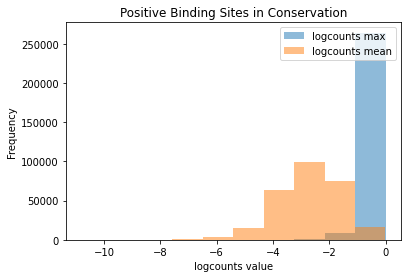

In [59]:
'''
Use conservation file as bigwig and loop through coordinates in the positive binding file. 
Adding to profile and log counts. It seems like they’re in general pretty accessible.

Looks at the positive files here. 
'''

# ignore the name
ACCESSIBILITY_FILE = "/users/angezhao/cs197_covariates/data/human/conservation/conservation.phastCons.bigWig"
POS_BIND = "/users/angezhao/cs197_covariates/data/human/CTCF/chr3toY_pos_shuf.bed.gz"

train_species = "mouse"
tf = "CTCF"
pos_conservation = Generator(train_species, tf, "val")

# histogram
plt.title("Positive Binding Sites in Conservation")
plt.xlabel("logcounts value")
plt.ylabel("Frequency")

plt.hist(pos_conservation.logcounts_max, alpha=0.5, label='logcounts max')
plt.hist(pos_conservation.logcounts_mean, alpha=0.5, label='logcounts mean')

plt.legend(loc='upper right')
# potentiall pick one exmaple (window), one strand, and then all 1000 bases
# sum, max over the window
plt.show()



Beginning Init
('chr15', 101395693, 101397807)
inside profiles
Finished going thorugh it all. 
(274016, 1000)  is 0th in profiles


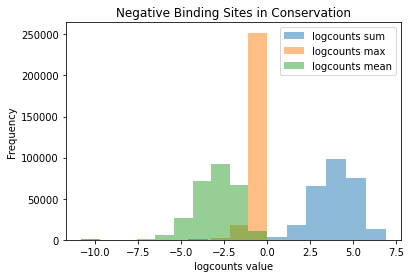

In [60]:
'''
Use conservation file as bigwig and loop through coordinates in the positive binding file. 
Adding to profile and log counts. It seems like they’re in general pretty accessible.

Looks at the negative files here. 
'''
# ignore the name
ACCESSIBILITY_FILE = "/users/angezhao/cs197_covariates/data/human/conservation/conservation.phastCons.bigWig"
# ignore the name - it's really the negative binding sites
POS_BIND = "/users/angezhao/cs197_covariates/data/human/CTCF/chr3toY_neg_shuf_run1_1E.bed.gz"

train_species = "mouse"
tf = "CTCF"
neg_conservation = Generator(train_species, tf, "val")

# histogram
plt.title("Negative Binding Sites in Conservation")
plt.xlabel("logcounts value")
plt.ylabel("Frequency")

plt.hist(neg_conservation.logcounts_sum, alpha=0.5, label='logcounts sum')
plt.hist(neg_conservation.logcounts_max, alpha=0.5, label='logcounts max')
plt.hist(neg_conservation.logcounts_mean, alpha=0.5, label='logcounts mean')

plt.legend(loc='upper right')

plt.show()


In [ ]:
'''
Use accessibility file as bigwig and loop through coordinates in the positive binding file. 
Adding to profile and log counts. It seems like they’re in general pretty accessible.

Looks at the positive files here. 
'''

ACCESSIBILITY_FILE = "/users/angezhao/cs197_covariates/data/human/accessibility/reads.bigWig"
POS_BIND = "/users/angezhao/cs197_covariates/data/human/CTCF/chr3toY_pos_shuf.bed.gz"

train_species = "mouse"
tf = "CTCF"
pos_accessibility = Generator(train_species, tf, "val")

# histogram
plt.title("Positive Binding Sites in Accessibility")
plt.xlabel("logcounts value")
plt.ylabel("Frequency")

plt.hist(pos_accessibility.logcounts_sum, alpha=0.5, label='logcounts sum')
plt.hist(pos_accessibility.logcounts_max, alpha=0.5, label='logcounts max')
plt.hist(pos_accessibility.logcounts_mean, alpha=0.5, label='logcounts mean')

plt.legend(loc='upper right')
# potentiall pick one exmaple (window), one strand, and then all 1000 bases
# sum, max over the window
plt.show()


In [ ]:
'''
Use accessibility file as bigwig and loop through coordinates in the positive binding file. 
Adding to profile and log counts. It seems like they’re in general pretty accessible.

Looks at the positive files here. 
'''

ACCESSIBILITY_FILE = "/users/angezhao/cs197_covariates/data/human/accessibility/reads.bigWig"
# ignore the name - it's really the negative binding sites
POS_BIND = "/users/angezhao/cs197_covariates/data/human/CTCF/chr3toY_neg_shuf_run1_1E.bed.gz"

train_species = "mouse"
tf = "CTCF"
neg_accessibility = Generator(train_species, tf, "val")

# histogram
plt.title("Negative Binding Sites in Accessibility")
plt.xlabel("logcounts value")
plt.ylabel("Frequency")

plt.hist(neg_accessibility.logcounts_sum, alpha=0.5, label='logcounts sum')
plt.hist(neg_accessibility.logcounts_max, alpha=0.5, label='logcounts max')
plt.hist(neg_accessibility.logcounts_mean, alpha=0.5, label='logcounts mean')

plt.legend(loc='upper right')
# potentiall pick one exmaple (window), one strand, and then all 1000 bases
# sum, max over the window
plt.show()


In [ ]:
plt.title("Logcounts Sum")
plt.xlabel("profiles")
plt.ylabel("logcounts sum")

# do not do the one below
plt.scatter(range(5), test.logcounts_sum[:5], s=5)

# potentiall pick one exmaple (window), one strand, and then all 1000 bases
# sum, max over the window
plt.show()


In [ ]:
plt.title("Logcounts Mean")
plt.xlabel("profiles")
plt.ylabel("logcounts mean")

# do not do the one below
plt.scatter(range(test.profiles.shape[0]), test.logcounts_mean, s=0.05)

# potentiall pick one exmaple (window), one strand, and then all 1000 bases
# sum, max over the window
plt.show()

In [ ]:
plt.title("Logcounts Max")
plt.xlabel("profiles")
plt.ylabel("logcounts Max")

# do not do the one below
plt.scatter(range(test.profiles.shape[0]), test.logcounts_max, s=0.05)

# potentiall pick one exmaple (window), one strand, and then all 1000 bases
# sum, max over the window
plt.show()

In [ ]:
# creating / graphing violiplots 
# build a violin plot

fig, ax = plt.subplots()
ax.violinplot(data, showmeans=False, showmedians=True)


# add title and axis labels
ax.set_title('violin plot')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')


# add x-tick labels
xticklabels = ['category 1', 'category 2', 'category 3', 'category 4']
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(xticklabels)

# add horizontal grid lines
ax.yaxis.grid(True)


# show the plot
plt.show()